In [94]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../preprocessing/Artifact_Removal/Batch_ArtifactFilter_Epoch.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../PCA/Emmanuil-PCA.ipynb


import os
import seaborn as sns
import mne
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

from sklearn import preprocessing
from mne.decoding import Vectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
matplotlib.rcParams.update({'font.size': 15})

ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.
ERROR:tornado.application:Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x000002502ACB36A8>)
Traceback (most recent call last):
  File "C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\ipykernel\kernelbase.py", line 306, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [2]:
path = 'D:\stim_code_epochs'
epoch_files = os.listdir(path)

In [3]:
np.random.seed(42)
n = np.random.randint(0,len(epoch_files))
print(n)

102


In [42]:
epoch = mne.read_epochs(os.path.join(path, epoch_files[5]), preload = True)

Reading D:\stim_code_epochs\20140207_1146_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
922 matching events found
Applying baseline correction (mode: mean)
922 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [5]:
epoch.events[900:]

array([[485663,      0,     14],
       [485896,      0,     21],
       [486171,      0,     13],
       [486731,      0,     14],
       [486981,      0,     21],
       [487231,      0,     13],
       [487799,      0,     14],
       [488075,      0,     21],
       [488299,      0,     13],
       [488867,      0,     14],
       [489151,      0,     21],
       [489410,      0,     13],
       [489978,      0,     14],
       [490245,      0,     21],
       [490486,      0,     13],
       [491046,      0,     14],
       [491296,      0,     21],
       [491537,      0,     13],
       [492106,      0,     14],
       [492347,      0,     21],
       [492588,      0,     13],
       [493165,      0,     14]])

In [6]:
493165 * 1/512

963.212890625

In [7]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [43]:
# reduce dimensions of n_times to a point for each band.
montage = mne.channels.read_montage(kind = 'ANT_DukeWaveGuard_128_electrode_montages_updated_V4')
epoch.set_montage(montage);
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);

The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.


<ipython-input-43-20254dd9ff05>:3: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.
  epoch.set_montage(montage);


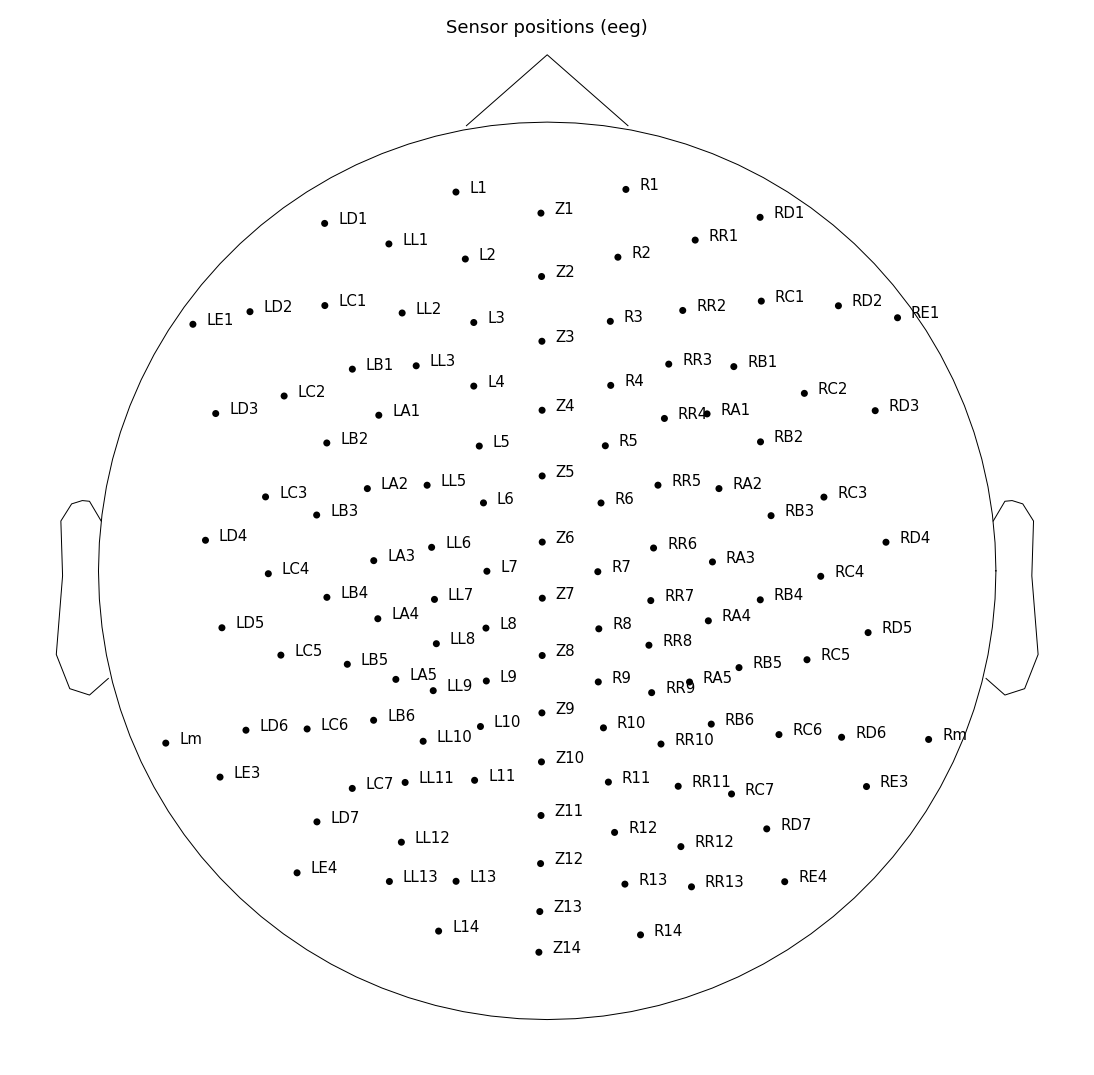

In [52]:
epoch.plot_sensors(show_names=True);

In [10]:
data = epoch.get_data()

In [11]:
new_events = convert_epoch_events_to_stim_combinations(epoch)
print(new_events.shape)

(921, 3)


In [12]:
epoch.events = new_events

In [13]:
# create arrays based on audio and visual
audio_epochs = []
visual_epochs = []

for i in range(len(epoch)): 
#     print(i)
    if epoch[i].events[:,-1][0] <700:
#         print("audio")
        audio_epochs.append(epoch[i].get_data())
    else:
#         print("visual")
        visual_epochs.append(epoch[i].get_data())

In [14]:
pipeline = make_pipeline(Vectorizer(), StandardScaler())
scaled_audio_data = pipeline.fit_transform(audio_epochs)
scaled_visual_data = pipeline.fit_transform(visual_epochs)

In [15]:
vectorizer = make_pipeline(Vectorizer())
vectorized_audio_data = vectorizer.fit_transform(audio_epochs)
vectorized_visual_data = vectorizer.fit_transform(visual_epochs)


In [16]:
scaled_audio_data = preprocessing.scale(vectorized_audio_data)
scaled_visual_data = preprocessing.scale(vectorized_visual_data)

In [17]:
audio_variance = []
for data in scaled_audio_data:
#     print(data)
    audio_variance.append(np.var(data))
visual_variance = []
for data in scaled_visual_data:
    visual_variance.append(np.var(data))

In [18]:
all_variance = []


In [20]:
np.array(audio_variance).shape

(534,)

In [21]:
def get_audio_visual_labels(epoch_object):
    events = epoch_object.events[:,-1]
    labels = []
    for event in events:
        if event < 700:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels) 

### extracting frequency bands

In [22]:
def get_frequency_band(band, epoch_object):
    """
    Description:
        returns an epoch object with a filtered frequency band
    
    Variables: 
        band : 
            'Theta':(4,7),
            'Alpha':(8,12),
            'Beta':(13,25),
            'Gamma':(30,45)
        epoch_object: mne.epoch
    -----
    returns: epoch object
    
    """
    iter_freqs = {
        'Theta':(4,7),
        'Alpha':(8,12),
        'Beta':(13,25),
        'Gamma':(30,45)
    }
    copy_epoch = epoch_object.copy()
    copy_epoch.filter(l_freq= iter_freqs[band][0],
                    h_freq = iter_freqs[band][1])
    
    return copy_epoch


In [23]:
gamma_epoch = get_frequency_band('Gamma', epoch)
theta_epoch = get_frequency_band('Theta', epoch)
beta_epoch = get_frequency_band('Beta', epoch)
alpha_epoch = get_frequency_band('Alpha',epoch)

Setting up band-pass filter from 30 - 45 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 113 samples (0.441 sec) selected
Setting up band-pass filter from 4 - 7 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 423 samples (1.652 sec) selected
Setting up band-pass filter from 13 - 25 Hz
l_trans_bandwidth chosen to be 3.2 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 261 samples (1.020 sec) selected
Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 423 samples (1.652 sec) selected


In [24]:
def variance_of_epochs(epoch_object):
    pipeline = make_pipeline(Vectorizer(), StandardScaler())
    
    scaled_epoch_data = pipeline.fit_transform(epoch_object.get_data())
    
    variance_epochs = []
    for data in scaled_epoch_data:
        variance_epochs.append(np.var(data))
    
    return np.array(variance_epochs)

In [25]:
def mean_of_epochs(epoch_object):
    pipeline = make_pipeline(Vectorizer(), StandardScaler())
    
    scaled_epoch_data = pipeline.fit_transform(epoch_object.get_data())
    
    mean_epochs = []
    for data in scaled_epoch_data:
        mean_epochs.append(np.mean(data))
    
    return np.array(mean_epochs)

In [26]:
variance_gamma_epochs = variance_of_epochs(gamma_epoch)
variance_theta_epochs = variance_of_epochs(theta_epoch)
variance_beta_epochs = variance_of_epochs(beta_epoch)
variance_alpha_epochs = variance_of_epochs(alpha_epoch)

In [27]:
variance_gamma_epochs = variance_gamma_epochs[:-1]
variance_theta_epochs = variance_theta_epochs[:-1]
variance_beta_epochs = variance_beta_epochs[:-1]
variance_alpha_epochs = variance_alpha_epochs[:-1]

In [28]:
variance_gamma_epochs.shape

(921,)

In [29]:
labels = get_audio_visual_labels(gamma_epoch)

In [30]:
alpha_epoch.events.shape

(921, 3)

In [31]:
epoch.events.shape

(921, 3)

In [32]:
print(variance_alpha_epochs.shape)
print(labels.shape)

(921,)
(921,)


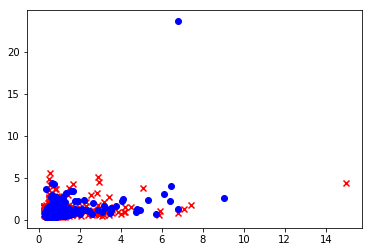

In [33]:
plt.scatter(variance_gamma_epochs[labels == 0], 
            variance_theta_epochs[labels == 0], c = 'red', marker = 'x');
plt.scatter(variance_gamma_epochs[labels == 1], 
            variance_theta_epochs[labels == 1], c = 'blue', marker = 'o');


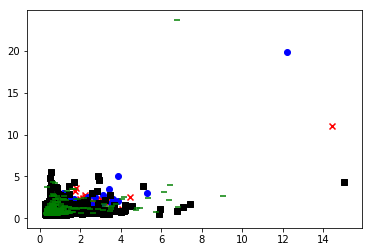

In [34]:
plt.scatter(variance_beta_epochs[labels == 0], 
            variance_alpha_epochs[labels == 0], c = 'red', marker = 'x');
plt.scatter(variance_beta_epochs[labels == 1], 
            variance_alpha_epochs[labels == 1], c = 'blue', marker = 'o');
plt.scatter(variance_gamma_epochs[labels == 0], 
            variance_theta_epochs[labels == 0], c = 'k', marker = 's');
plt.scatter(variance_gamma_epochs[labels == 1], 
            variance_theta_epochs[labels == 1], c = 'green', marker = '_');


    using multitaper spectrum estimation with 7 DPSS windows


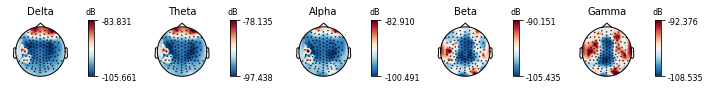

In [35]:
epoch.plot_psd_topomap(ch_type='eeg');

    using multitaper spectrum estimation with 7 DPSS windows


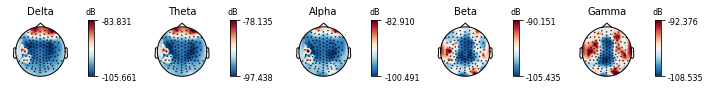

In [36]:
epoch.plot_psd_topomap(ch_type='eeg');

In [ ]:
epoch.plot_image();

In [38]:
visual_channels = ['RC7','RD7','RE4','R12','R13','RR12','RR13',
                   'LC7','LD7',';LE4','L12','L13','LL12','LL13']
audio_channels = [x for x in epoch.ch_names if 'LD' in x or 'LC' in x or 'LA' in x
                  or 'RD' in x or 'RC' in x or 'RA' in x]

In [39]:
bad_channels = []
for ch in epoch.ch_names:
    if ch not in visual_channels and ch not in audio_channels:
        bad_channels.append(ch)

In [55]:
epoch.drop_channels(ch_names= bad_channels)

<EpochsFIF  |   922 events (all good), 0 - 1.94922 sec, baseline [0, 0], ~162.0 MB, data loaded,
 'b-f1-pic': 60
 'b-f1-snd': 20
 'b-f1-spk': 40
 'b-f1-wrd': 40
 'b-f2-pic': 60
 'b-f2-snd': 20
 'b-f2-spk': 40
 'b-f2-wrd': 40
 'b-tg-pic': 20
 'b-tg-snd': 60
 'b-tg-spk': 40
 'b-tg-wrd': 40
 'f-f1-pic': 40
 'f-f1-snd': 60
 'f-f1-spk': 20
 'f-f1-wrd': 28
 'f-f2-pic': 40
 'f-f2-snd': 60
 'f-f2-spk': 20
 'f-f2-wrd': 27
 'f-tg-pic': 29
 'f-tg-snd': 40
 'f-tg-spk': 38
 'f-tg-wrd': 40>

In [56]:
epoch.get_data().shape

(922, 46, 500)

In [57]:
gamma_epoch = get_frequency_band('Gamma', epoch)

Setting up band-pass filter from 30 - 45 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 113 samples (0.441 sec) selected


In [ ]:
pipeline = make_pipeline(Vectorizer(), StandardScaler())

In [68]:
mean_stats = get_mean_band(gamma_epoch[:-1])
mean_stats = mean_stats.swapaxes(1,2)

In [74]:
audio_visual_events = []
for event in new_events:
    if event[-1] < 700:
        event[-1] = 100
    else:
        event[-1] = 101

In [75]:
epoch.events = new_events

In [77]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(mean_stats))
for train, test in cv.split(mean_stats, labels):
    start = time.time()
    clf.fit(mean_stats[train], labels[train])
    preds[test] = clf.predict(mean_stats[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio', 'Visual']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

clf elapsed time: 0.0009930133819580078
kfold elapsed time: 0.17228484153747559


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 0.23537230491638184
kfold elapsed time: 0.09968900680541992
kfold elapsed time: 0.06183481216430664


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 0.1515951156616211
classification elapsed time: 0.7227528095245361
              precision    recall  f1-score   support

       Audio       0.81      0.83      0.82       534
      Visual       0.75      0.73      0.74       387

   micro avg       0.79      0.79      0.79       921
   macro avg       0.78      0.78      0.78       921
weighted avg       0.79      0.79      0.79       921

reporting elapsed time: 0.002991914749145508


In [81]:
test_epoch = mne.read_epochs(os.path.join(path, epoch_files[6]), preload = True)

Reading D:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [84]:
test_events = convert_epoch_events_to_stim_combinations(test_epoch)

In [86]:
test_epoch_gamma = get_frequency_band('Gamma', test_epoch)
test_epoch_gamma = test_epoch_gamma[:-1]

Setting up band-pass filter from 30 - 45 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 113 samples (0.441 sec) selected


In [87]:
test_epoch_gamma.get_data().shape

(939, 129, 500)

In [89]:
for event in test_events:
    if event[-1] < 700:
        event[-1] = 100
    else:
        event[-1] = 101

In [85]:
test_events.shape

(939, 3)

In [91]:
vect_scale = make_pipeline(Vectorizer(),
                    StandardScaler())
scaled_test_epoch_gamma_data = vect_scale.fit_transform(test_epoch_gamma)

In [92]:
clf.score(scaled_test_epoch_gamma_data, test_events[:,-1])

ValueError: Shape of X used in fit and transform must be same

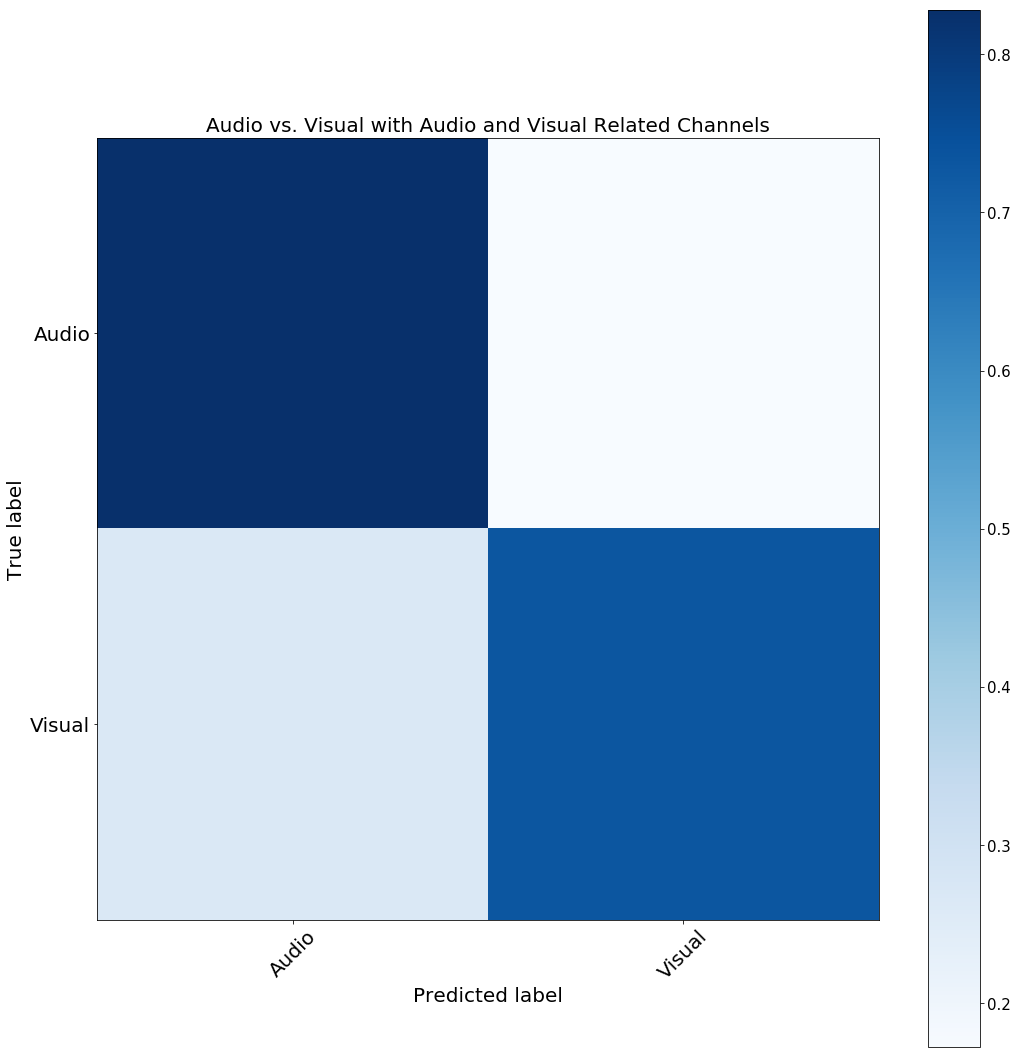

In [99]:
cm3 = confusion_matrix(labels, preds)
cm3_normalized = cm3.astype(float) / cm3.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm3_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Audio vs. Visual with Audio and Visual Related Channels', size = 20)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, size = 20)
plt.yticks(tick_marks, target_names,size = 20)
tight_layout()
plt.ylabel('True label',size = 20)
plt.xlabel('Predicted label',size = 20)
plt.show()

In [67]:
new_events.shape

(921, 3)